In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [34]:
from proj1_helpers import *
from validation_helpers import *
from plots import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [35]:
from implementations import *

## Do your thing crazy machine learning thing here :) ...

In [4]:
split_x, split_y, split_ids = separate(y, tX, ids)

In [5]:
selection = dataStatistics(split_x)

Statistics 
Type :
0
[0.26145747 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 1.         1.         1.         1.         1.         0.        ]
Statistics 
Type :
1
[0.09751883 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05859584 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.0

In [6]:
cleaned = removeNone(split_x, selection)



# Now we can either drop the lines with residual Nones or replace the Nones by the median value

In [7]:
cleaned_with_median = putMedianInsteadOfNone(cleaned)

cleaned_with_median_with_momentum = add_momentum_vector(cleaned_with_median)

In [8]:
dropped_x, dropped_y, dropped_ids = dropLineIfNone(cleaned, split_y, split_ids)


## At this point, the first values in each of the split data has a PRI_jet_num = 0, then 1 and so on. The data is clean and we can work with it.

## Generate predictions and save ouput in csv format for submission:

In [9]:
DATA_TEST_PATH = '../data/test.csv' 
y_donotUse, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [53]:
#separate data with respect to column 24 and remove None
split_x_test, _, split_ids_test =  separate(y_donotUse, tX_test, ids_test)


split_x_cleaned_test = removeNone(split_x_test, dataStatistics(split_x_test))

#median instead of None
split_x_with_median = putMedianInsteadOfNone(split_x_cleaned_test)

split_x_with_median_with_momentum = add_momentum_vector(split_x_with_median)

#line dropped when None
#split_x_drop_lines, split_y_dropped_split_indexes_dropped = dropLineIfNone(split_x_cleaned_test, _, split_ids_test)

#degrees for polynomial feature expension
degrees = [1,2,3,4,5,6,7,8]

y_res = []

acc = []

plot_data_per_jetnum = []


for i in range(len(cleaned_with_median)):
    
    
    
    #training: chose either cross calidation or cross validation for logistic regression with regularization
    #w_star, d, accuracy, training_set, plot_data = crossValidation(cleaned_with_median[i], split_y[i], 0.98, degrees ,6)
    w_star, d, accuracy, training_set, plot_data = crossValidationForLogistic_reg_with_loss(cleaned_with_median[i], split_y[i], 0.9, degrees ,6)
    
    
    #polynomial feature expension and normalization using the training data
    mean = np.mean(build_poly(training_set,d), axis = 0)
    std = np.std(build_poly(training_set,d), axis = 0)
    
      
    #put 1 if std = 0
    std = std + (std == 0)
    
    extended_and_normalized = (build_poly(split_x_with_median[i], d) - mean) / std
    
    #adding bias term
    bias = np.ones(shape=split_x_with_median[i].shape)          
    x_test_ready = np.c_[bias, extended_and_normalized]
    
    #prediction for least squares
    #y_res.append(predict_labels(w_star, x_test_ready))
    
    #prediction for logistic
    y_res.append(predict_labels_logistic(w_star, x_test_ready))


    acc.append(accuracy)
    plot_data_per_jetnum.append(plot_data)

print("Accuracy per jet nbr: \n")
print(acc)


Statistics 
Type :
0
[0.2605448 0.        0.        0.        1.        1.        1.
 0.        0.        0.        0.        0.        1.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.        1.        1.        1.        1.
 1.        0.       ]
Statistics 
Type :
1
[0.09834149 0.         0.         0.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         0.        ]
Statistics 
Type :
2
[0.05881481 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Statistics 
Type :
3
[0.06376737 0.         0.     

lambda=0.00100,degree=6, gamma=0.41000, Training Loss=22608337.006144874, Testing Loss=22608337.006144874
lambda=0.00100,degree=6, gamma=0.61000, Training Loss=49467998.277732804, Testing Loss=49467998.277732804
lambda=0.00100,degree=6, gamma=0.81000, Training Loss=86217001.98238134, Testing Loss=86217001.98238134
lambda=0.00100,degree=7, gamma=0.01000, Training Loss=12734.897243669657, Testing Loss=12734.897243669657
lambda=0.00100,degree=7, gamma=0.21000, Training Loss=5566428.814798247, Testing Loss=5566428.814798247
lambda=0.00100,degree=7, gamma=0.41000, Training Loss=20974440.029324137, Testing Loss=20974440.029324137
lambda=0.00100,degree=7, gamma=0.61000, Training Loss=45893046.70034401, Testing Loss=45893046.70034401
lambda=0.00100,degree=7, gamma=0.81000, Training Loss=79986348.94041297, Testing Loss=79986348.94041297
lambda=0.00100,degree=8, gamma=0.01000, Training Loss=9830.943599775544, Testing Loss=9830.943599775544
lambda=0.00100,degree=8, gamma=0.21000, Training Loss=43

lambda=0.00000,degree=6, gamma=0.21000, Training Loss=3411.8247157883266, Testing Loss=3411.8247157883266
lambda=0.00000,degree=6, gamma=0.41000, Training Loss=13006.312124023998, Testing Loss=13006.312124023998
lambda=0.00000,degree=6, gamma=0.61000, Training Loss=28790.95192100404, Testing Loss=28790.95192100404
lambda=0.00000,degree=6, gamma=0.81000, Training Loss=50765.5286865819, Testing Loss=50765.5286865819
lambda=0.00000,degree=7, gamma=0.01000, Training Loss=7.158784910136294, Testing Loss=7.158784910136294
lambda=0.00000,degree=7, gamma=0.21000, Training Loss=3171.0824041768515, Testing Loss=3171.0824041768515
lambda=0.00000,degree=7, gamma=0.41000, Training Loss=12088.68177194678, Testing Loss=12088.68177194678
lambda=0.00000,degree=7, gamma=0.61000, Training Loss=26759.756660063875, Testing Loss=26759.756660063875
lambda=0.00000,degree=7, gamma=0.81000, Training Loss=47184.106844937225, Testing Loss=47184.106844937225
lambda=0.00000,degree=8, gamma=0.01000, Training Loss=6.

lambda=0.00200,degree=6, gamma=0.01000, Training Loss=15400.074519950651, Testing Loss=15400.074519950651
lambda=0.00200,degree=6, gamma=0.21000, Training Loss=6662729.762881147, Testing Loss=6662729.762881147
lambda=0.00200,degree=6, gamma=0.41000, Training Loss=24816342.289588455, Testing Loss=24816342.289588455
lambda=0.00200,degree=6, gamma=0.61000, Training Loss=53672730.89726567, Testing Loss=53672730.89726567
lambda=0.00200,degree=6, gamma=0.81000, Training Loss=92464836.89469951, Testing Loss=92464836.89469951
lambda=0.00200,degree=7, gamma=0.01000, Training Loss=14308.122722304735, Testing Loss=14308.122722304735
lambda=0.00200,degree=7, gamma=0.21000, Training Loss=6192599.866803826, Testing Loss=6192599.866803826
lambda=0.00200,degree=7, gamma=0.41000, Training Loss=23065482.680666834, Testing Loss=23065482.680666834
lambda=0.00200,degree=7, gamma=0.61000, Training Loss=49886132.04946032, Testing Loss=49886132.04946032
lambda=0.00200,degree=7, gamma=0.81000, Training Loss=85

lambda=0.00100,degree=5, gamma=0.81000, Training Loss=30125881.931802038, Testing Loss=30125881.931802038
lambda=0.00100,degree=6, gamma=0.01000, Training Loss=4461.741161117539, Testing Loss=4461.741161117539
lambda=0.00100,degree=6, gamma=0.21000, Training Loss=1956546.8345962754, Testing Loss=1956546.8345962754
lambda=0.00100,degree=6, gamma=0.41000, Training Loss=7372901.106381918, Testing Loss=7372901.106381918
lambda=0.00100,degree=6, gamma=0.61000, Training Loss=16132689.828901686, Testing Loss=16132689.828901686
lambda=0.00100,degree=6, gamma=0.81000, Training Loss=28117828.065590613, Testing Loss=28117828.065590613
lambda=0.00100,degree=7, gamma=0.01000, Training Loss=4175.06110690511, Testing Loss=4175.06110690511
lambda=0.00100,degree=7, gamma=0.21000, Training Loss=1831748.4922450369, Testing Loss=1831748.4922450369
lambda=0.00100,degree=7, gamma=0.41000, Training Loss=6902705.853665199, Testing Loss=6902705.853665199
lambda=0.00100,degree=7, gamma=0.61000, Training Loss=15

lambda=0.00000,degree=5, gamma=0.61000, Training Loss=3357.5529796281344, Testing Loss=3357.5529796281344
lambda=0.00000,degree=5, gamma=0.81000, Training Loss=5920.412735509366, Testing Loss=5920.412735509366
lambda=0.00000,degree=6, gamma=0.01000, Training Loss=0.8383186531985164, Testing Loss=0.8383186531985164
lambda=0.00000,degree=6, gamma=0.21000, Training Loss=374.8483619390147, Testing Loss=374.8483619390147
lambda=0.00000,degree=6, gamma=0.41000, Training Loss=1429.3143574375197, Testing Loss=1429.3143574375197
lambda=0.00000,degree=6, gamma=0.61000, Training Loss=3164.212625253264, Testing Loss=3164.212625253264
lambda=0.00000,degree=6, gamma=0.81000, Training Loss=5579.519486030688, Testing Loss=5579.519486030688
lambda=0.00000,degree=7, gamma=0.01000, Training Loss=0.7801374953626896, Testing Loss=0.7801374953626896
lambda=0.00000,degree=7, gamma=0.21000, Training Loss=349.2620905093284, Testing Loss=349.2620905093284
lambda=0.00000,degree=7, gamma=0.41000, Training Loss=13

lambda=0.00200,degree=5, gamma=0.41000, Training Loss=2893827.629219058, Testing Loss=2893827.629219058
lambda=0.00200,degree=5, gamma=0.61000, Training Loss=6259225.860218038, Testing Loss=6259225.860218038
lambda=0.00200,degree=5, gamma=0.81000, Training Loss=10783500.401382606, Testing Loss=10783500.401382606
lambda=0.00200,degree=6, gamma=0.01000, Training Loss=1675.5313445948475, Testing Loss=1675.5313445948475
lambda=0.00200,degree=6, gamma=0.21000, Training Loss=732017.0477262138, Testing Loss=732017.0477262138
lambda=0.00200,degree=6, gamma=0.41000, Training Loss=2727165.1916783513, Testing Loss=2727165.1916783513
lambda=0.00200,degree=6, gamma=0.61000, Training Loss=5898796.554716181, Testing Loss=5898796.554716181
lambda=0.00200,degree=6, gamma=0.81000, Training Loss=10162594.17958707, Testing Loss=10162594.17958707
lambda=0.00200,degree=7, gamma=0.01000, Training Loss=1559.2458242405723, Testing Loss=1559.2458242405723
lambda=0.00200,degree=7, gamma=0.21000, Training Loss=68

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

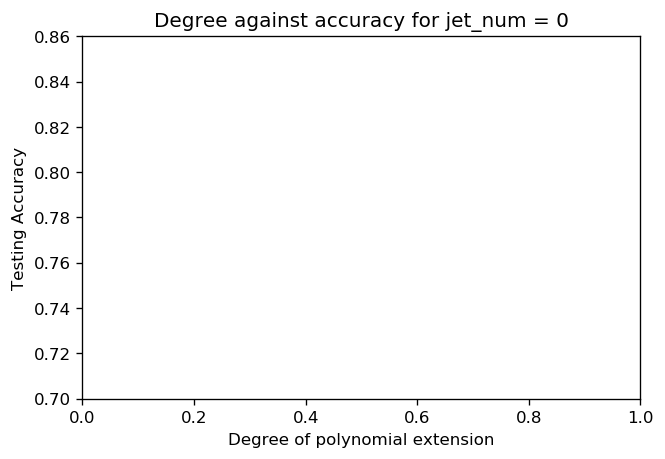

In [54]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

for i in range(len(plot_data_per_jetnum)):
    jet_num = plot_data_per_jetnum[i]



    X = np.array([x[0] for x in jet_num])
    Y = np.array([x[1] for x in jet_num])
    Z = np.array([x[3] for x in jet_num])
    

    plt.figure(dpi=120)
    plt.title('Degree against accuracy for jet_num = %d' %i)
    plt.xlabel('Degree of polynomial extension')
    plt.ylabel('Testing Accuracy')

    axes = plt.gca()
    axes.set_ylim([0.7,0.86])

    plt.stem(Y, Z, use_line_collection=True, label="hello")
    plt.savefig("cross_with_momentum_"+str(i))
    plt.show()


In [62]:
OUTPUT_PATH = '../data/submission.csv'
#reassemble the data for the submission
y_pred = put_together(y_res, split_ids_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)